In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using TrajOptPlots
using StaticArrays
using Printf

  Activating project at `~/CMU/Study/18660 Optimization/project/OptimizationFinalProj`


  Installing 

known registries into `~/.julia`


    Updating registry at `~/.julia/registries/General.toml`


   Installed libfdk_aac_jll ─────────────── v2.0.2+0
   Installed JpegTurbo_jll ──────────────── v2.1.91+0


   Installed x265_jll ───────────────────── v3.5.0+0
   Installed GR_jll ─────────────────────── v0.72.0+0
   Installed LERC_jll ───────────────────── v3.0.0+1
   Installed Libmount_jll ───────────────── v2.35.0+0
   Installed OffsetArrays ───────────────── v1.12.9
   Installed MutableArithmetics ─────────── v0.2.22


   Installed Opus_jll ───────────────────── v1.3.2+0
   Installed Preferences ────────────────── v1.3.0
   Installed Xorg_xkbcomp_jll ───────────── v1.4.2+4
   Installed RelocatableFolders ─────────── v1.0.0


   Installed Contour ────────────────────── v0.6.2


   Installed TimerOutputs ───────────────── v0.5.22
   Installed EarCut_jll ─────────────────── v2.2.4+0
   Installed Measures ───────────────────── v0.3.2
   Installed Grisu ──────────────────────── v1.0.2
   Installed StaticArrays ───────────────── v1.5.21
   Installed Pidfile ────────────────────── v1.3.0


   Installed ColorSchemes ───────────────── v3.20.0


   Installed GR ─────────────────────────── v0.72.0
   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1
   Installed Xorg_xcb_util_image_jll ────── v0.4.0+1


   Installed PlotUtils ──────────────────── v1.3.4
   Installed URIParser ──────────────────── v0.4.1
   Installed Formatting ─────────────────── v0.4.2


   Installed Xorg_libpthread_stubs_jll ──── v0.1.0+3


   Installed AMD ────────────────────────── v0.4.0
   Installed FileIO ─────────────────────── v1.16.0


   Installed MeshCat ────────────────────── v0.13.2
   Installed ECOS ───────────────────────── v0.12.3
   Installed HTTP ───────────────────────── v0.9.17
   Installed Cairo_jll ──────────────────── v1.16.1+1


   Installed Xorg_xcb_util_jll ──────────── v0.4.0+1
   Installed OpenBLAS32_jll ─────────────── v0.3.17+0


   Installed Fontconfig_jll ─────────────── v2.13.93+0
   Installed Xorg_libxkbfile_jll ────────── v1.1.0+4
   Installed Libgpg_error_jll ───────────── v1.42.0+0
   Installed Convex ─────────────────────── v0.14.18


   Installed Xorg_libXau_jll ────────────── v1.0.9+4
   Installed Xorg_libXinerama_jll ───────── v1.1.4+4
   Installed Missings ───────────────────── v1.1.0
   Installed BinDeps ────────────────────── v1.0.2
   Installed FiniteDiff ─────────────────── v2.19.0


   Installed RecipesPipeline ────────────── v0.6.11


   Installed FFMPEG ─────────────────────── v0.4.1
   Installed RealDot ────────────────────── v0.1.0
   Installed JLD2 ───────────────────────── v0.4.31
   Installed WebIO ──────────────────────── v0.8.20
   Installed Showoff ────────────────────── v1.0.3
   Installed ArnoldiMethod ──────────────── v0.2.0
   Installed MathOptInterface ───────────── v0.9.22


   Installed MUMPS_seq_jll ──────────────── v5.2.1+4
   Installed Qt5Base_jll ────────────────── v5.15.3+2
   Installed Xorg_xcb_util_keysyms_jll ──── v0.4.0+1
   Installed xkbcommon_jll ──────────────── v1.4.1+0
   Installed IrrationalConstants ────────── v0.2.2
   Installed JSON ───────────────────────── v0.21.4
   Installed SpecialFunctions ───────────── v2.2.0
   Installed Blink ──────────────────────── v0.12.5


   Installed HarfBuzz_jll ───────────────── v2.8.1+1
   Installed CodecBzip2 ─────────────────── v0.7.2
   Installed Bzip2_jll ──────────────────── v1.0.8+0
   Installed PlotThemes ─────────────────── v3.1.0
   Installed BenchmarkTools ─────────────── v0.5.0
   Installed Pipe ───────────────────────── v1.3.0
   Installed StaticArraysCore ───────────── v1.4.0


   Installed NaNMath ────────────────────── v1.0.2
   Installed AssetRegistry ──────────────── v0.1.0


   Installed MsgPack ────────────────────── v1.2.0


   Installed LZO_jll ────────────────────── v2.10.1+0
   Installed PyPlot ─────────────────────── v2.11.1
   Installed TranscodingStreams ─────────── v0.9.12


   Installed fzf_jll ────────────────────── v0.29.0+0
   Installed FriBidi_jll ────────────────── v1.0.10+0
   Installed SnoopPrecompile ────────────── v1.0.3


   Installed Ipopt_jll ──────────────────── v3.13.4+2
   Installed UnicodeFun ─────────────────── v0.4.1


   Installed MathProgBase ───────────────── v0.7.8


   Installed GLFW_jll ───────────────────── v3.3.8+0
   Installed UnsafeArrays ───────────────── v1.0.4
   Installed MbedTLS ────────────────────── v1.1.7
   Installed RobotZoo ───────────────────── v0.2.3
   Installed Hiccup ─────────────────────── v0.2.2


   Installed Ratios ─────────────────────── v0.4.3
   Installed Graphs ─────────────────────── v1.8.0


   Installed x264_jll ───────────────────── v2021.5.5+0
   Installed FreeType2_jll ──────────────── v2.10.4+0


   Installed JLFzf ──────────────────────── v0.1.5
   Installed Colors ─────────────────────── v0.12.10
   Installed DataStructures ─────────────── v0.18.13
   Installed ExprTools ──────────────────── v0.1.9
   Installed CommonSubexpressions ───────── v0.3.0
   Installed BinaryProvider ─────────────── v0.5.10
   Installed StatsAPI ───────────────────── v1.6.0


   Installed CodecZlib ──────────────────── v0.7.1
   Installed Compat ─────────────────────── v4.6.1
   Installed libpng_jll ─────────────────── v1.6.38+0
   Installed Xorg_libxcb_jll ────────────── v1.13.0+3
   Installed METIS_jll ──────────────────── v5.1.2+0
   Installed Lazy ───────────────────────── v0.15.1
   Installed SolverLogging ──────────────── v0.1.0
   Installed StatsBase ──────────────────── v0.33.21


   Installed libaom_jll ─────────────────── v3.4.0+0
   Installed Scratch ────────────────────── v1.2.0
   Installed ECOS_jll ───────────────────── v2.0.5+1


   Installed Xorg_libXext_jll ───────────── v1.3.4+4
   Installed ColorTypes ─────────────────── v0.11.4
   Installed DiffRules ──────────────────── v1.13.0
   Installed WebSockets ─────────────────── v1.5.9
   Installed Plots ──────────────────────── v1.38.10
   Installed Conda ──────────────────────── v1.8.0


   Installed Zstd_jll ───────────────────── v1.5.5+0


   Installed TensorCore ─────────────────── v0.1.1


   Installed Expat_jll ──────────────────── v2.4.8+0
   Installed TableTraits ────────────────── v1.0.1
   Installed DiffResults ────────────────── v1.1.0
   Installed Mustache ───────────────────── v1.0.15
   Installed Inflate ────────────────────── v0.1.3
   Installed Parsers ────────────────────── v2.5.8


   Installed PyCall ─────────────────────── v1.95.1
   Installed JSONSchema ─────────────────── v0.3.4
   Installed OSQP_jll ───────────────────── v0.600.200+0


   Installed Libtiff_jll ────────────────── v4.4.0+0
   Installed Setfield ───────────────────── v1.1.1
   Installed ConstructionBase ───────────── v1.5.1
   Installed JLLWrappers ────────────────── v1.4.1
   Installed DataValueInterfaces ────────── v1.0.0
   Installed Libffi_jll ─────────────────── v3.2.2+1


   Installed ColorVectorSpace ───────────── v0.9.10
   Installed OrderedCollections ─────────── v1.6.0
   Installed AbstractTrees ──────────────── v0.3.4
   Installed Xorg_libXrender_jll ────────── v0.9.10+4
   Installed CoordinateTransformations ──── v0.6.2


   Installed Ogg_jll ────────────────────── v1.3.5+1
   Installed XSLT_jll ───────────────────── v1.1.34+0
   Installed Xorg_libXi_jll ─────────────── v1.7.10+4
   Installed ArrayInterface ─────────────── v7.4.3
   Installed ChainRulesCore ─────────────── v1.15.7
   Installed MeshIO ─────────────────────── v0.4.7


   Installed Reexport ───────────────────── v1.2.2


   Installed LogExpFunctions ────────────── v0.3.23
   Installed MacroTools ─────────────────── v0.5.10
   Installed Rotations ──────────────────── v1.4.0
   Installed Quaternions ────────────────── v0.7.4
   Installed TrajectoryOptimization ─────── v0.5.0


   Installed OpenSpecFun_jll ────────────── v0.5.5+0
   Installed ASL_jll ────────────────────── v0.1.3+0
   Installed Xorg_libXcursor_jll ────────── v1.2.0+4
   Installed UnPack ─────────────────────── v1.0.2
   Installed InverseFunctions ───────────── v0.1.8
   Installed OSQP ───────────────────────── v0.6.1


   Installed Libuuid_jll ────────────────── v2.36.0+0
   Installed GPUArraysCore ──────────────── v0.1.4
   Installed Wayland_protocols_jll ──────── v1.25.0+0
   Installed SimpleTraits ───────────────── v0.9.4
   Installed Widgets ────────────────────── v0.6.6
   Installed DocStringExtensions ────────── v0.8.6


   Installed Xorg_xcb_util_renderutil_jll ─ v0.3.9+1


   Installed Graphite2_jll ──────────────── v1.3.14+0
   Installed libass_jll ─────────────────── v0.15.1+0
   Installed Pixman_jll ─────────────────── v0.40.1+0
   Installed Crayons ────────────────────── v4.1.1
   Installed Adapt ──────────────────────── v3.6.1
   Installed Interpolations ─────────────── v0.13.6


   Installed XML2_jll ───────────────────── v2.10.3+0
   Installed JSExpr ─────────────────────── v0.5.4
   Installed Wayland_jll ────────────────── v1.21.0+0


   Installed Gettext_jll ────────────────── v0.21.0+0
   Installed IterTools ──────────────────── v1.4.0
   Installed Cassette ───────────────────── v0.3.11
   Installed Xorg_xtrans_jll ────────────── v1.4.0+3
   Installed OpenSSL_jll ────────────────── v1.1.20+0
   Installed Latexify ───────────────────── v0.15.18
   Installed FFMPEG_jll ─────────────────── v4.4.2+2


   Installed FunctionalCollections ──────── v0.5.0
   Installed Libgcrypt_jll ──────────────── v1.8.7+0
   Installed Tables ─────────────────────── v1.10.1
   Installed GeometryBasics ─────────────── v0.3.13


   Installed Xorg_xkeyboard_config_jll ──── v2.27.0+4
   Installed VertexSafeGraphs ───────────── v0.2.0
   Installed Ipopt ──────────────────────── v0.7.0


   Installed Xorg_libXrandr_jll ─────────── v1.5.2+4
   Installed RecipesBase ────────────────── v1.3.3
   Installed DataAPI ────────────────────── v1.14.0
   Installed FixedPointNumbers ──────────── v0.8.4
   Installed Xorg_libXfixes_jll ─────────── v5.0.3+4
   Installed LAME_jll ───────────────────── v3.100.1+0
   Installed Mux ────────────────────────── v0.7.6


   Installed IteratorInterfaceExtensions ── v1.0.0


   Installed IniFile ────────────────────── v0.5.1
   Installed VersionParsing ─────────────── v1.3.0
   Installed Libiconv_jll ───────────────── v1.16.1+2
   Installed StructArrays ───────────────── v0.6.15
   Installed URIs ───────────────────────── v1.4.2


   Installed LaTeXStrings ───────────────── v1.3.0
   Installed Glib_jll ───────────────────── v2.74.0+2
   Installed libvorbis_jll ──────────────── v1.3.7+1
   Installed Libglvnd_jll ───────────────── v1.6.0+0
   Installed Altro ──────────────────────── v0.4.0
   Installed RobotDynamics ──────────────── v0.3.4
   Installed LDLFactorizations ──────────── v0.8.2


   Installed Xorg_libXdmcp_jll ──────────── v1.1.3+4
   Installed Xorg_libX11_jll ────────────── v1.6.9+4
   Installed AxisAlgorithms ─────────────── v1.0.1
   Installed Requires ───────────────────── v1.3.0
   Installed ForwardDiff ────────────────── v0.10.35
   Installed Observables ────────────────── v0.5.4
   Installed Parameters ─────────────────── v0.12.3


   Installed Unzip ──────────────────────── v0.2.0
   Installed SortingAlgorithms ──────────── v1.1.0
   Installed WoodburyMatrices ───────────── v0.5.5
   Installed ChangesOfVariables ─────────── v0.1.6
   Installed SparseDiffTools ────────────── v1.31.0


   Installed TrajOptPlots ───────────────── v0.2.0


    Updating `~/CMU/Study/18660 Optimization/project/OptimizationFinalProj/Project.toml`
⌃ [5dcf52e5] + Altro v0.4.0
  [5ae59095] + Colors v0.12.10
⌃ [f65535da] + Convex v0.14.18
⌃ [e2685f51] + ECOS v0.12.3
  [6a86dc24] + FiniteDiff v2.19.0
  [f6369f11] + ForwardDiff v0.10.35
⌃ [b6b21f68] + Ipopt v0.7.0
  [033835bb] + JLD2 v0.4.31
⌅ [b8f27783] + MathOptInterface v0.9.22
⌅ [283c5d60] + MeshCat v0.13.2
⌃ [ab2f91bb] + OSQP v0.6.1
  [91a5bcdd] + Plots v1.38.10
  [d330b81b] + PyPlot v2.11.1
⌅ [38ceca67] + RobotDynamics v0.3.4
⌅ [74be38bb] + RobotZoo v0.2.3
  [90137ffa] + StaticArrays v1.5.21
  [7770976a] + TrajOptPlots v0.2.0
⌅ [c79d492b] + TrajectoryOptimization v0.5.0
    Updating `~/CMU/Study/18660 Optimization/project/OptimizationFinalProj/Manifest.toml`


⌅ [14f7f29c] + AMD v0.4.0
⌅ [1520ce14] + AbstractTrees v0.3.4
  [79e6a3ab] + Adapt v3.6.1
⌃ [5dcf52e5] + Altro v0.4.0
  [ec485272] + ArnoldiMethod v0.2.0
  [4fba245c] + ArrayInterface v7.4.3
  [bf4720bc] + AssetRegistry v0.1.0
  [13072b0f] + AxisAlgorithms v1.0.1
⌅ [6e4b80f9] + BenchmarkTools v0.5.0
  [9e28174c] + BinDeps v1.0.2
  [b99e7846] + BinaryProvider v0.5.10
⌃ [ad839575] + Blink v0.12.5
  [7057c7e9] + Cassette v0.3.11
  [d360d2e6] + ChainRulesCore v1.15.7
  [9e997f8a] + ChangesOfVariables v0.1.6
  [523fee87] + CodecBzip2 v0.7.2
  [944b1d66] + CodecZlib v0.7.1
  [35d6a980] + ColorSchemes v3.20.0
  [3da002f7] + ColorTypes v0.11.4
  [c3611d14] + ColorVectorSpace v0.9.10
  [5ae59095] + Colors v0.12.10
  [bbf7d656] + CommonSubexpressions v0.3.0
  [34da2185] + Compat v4.6.1
  [8f4d0f93] + Conda v1.8.0
  [187b0558] + ConstructionBase v1.5.1
  [d38c429a] + Contour v0.6.2
⌃ [f65535da] + Convex v0.14.18
  [150eb455] + CoordinateTransformations v0.6.2
  [a8cc5b0e] + Crayons v4.1.1
  [9a96

  [02c8fc9c] + XML2_jll v2.10.3+0
  [aed1982a] + XSLT_jll v1.1.34+0
  [4f6342f7] + Xorg_libX11_jll v1.6.9+4
  [0c0b7dd1] + Xorg_libXau_jll v1.0.9+4
  [935fb764] + Xorg_libXcursor_jll v1.2.0+4
  [a3789734] + Xorg_libXdmcp_jll v1.1.3+4
  [1082639a] + Xorg_libXext_jll v1.3.4+4
  [d091e8ba] + Xorg_libXfixes_jll v5.0.3+4
  [a51aa0fd] + Xorg_libXi_jll v1.7.10+4
  [d1454406] + Xorg_libXinerama_jll v1.1.4+4
  [ec84b674] + Xorg_libXrandr_jll v1.5.2+4
  [ea2f1a96] + Xorg_libXrender_jll v0.9.10+4
  [14d82f49] + Xorg_libpthread_stubs_jll v0.1.0+3
  [c7cfdc94] + Xorg_libxcb_jll v1.13.0+3
  [cc61e674] + Xorg_libxkbfile_jll v1.1.0+4
  [12413925] + Xorg_xcb_util_image_jll v0.4.0+1
  [2def613f] + Xorg_xcb_util_jll v0.4.0+1
  [975044d2] + Xorg_xcb_util_keysyms_jll v0.4.0+1
  [0d47668e] + Xorg_xcb_util_renderutil_jll v0.3.9+1
  [c22f9ab0] + Xorg_xcb_util_wm_jll v0.4.1+1
  [35661453] + Xorg_xkbcomp_jll v1.4.2+4
  [33bec58e] + Xorg_xkeyboard_config_jll v2.27.0+4
  [c5fb5394] + Xorg_xtrans_jll v1.4.0+3
  [3

    Building Conda ──→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/e32a90da027ca45d84678b826fffd3110bb3fc90/build.log`


    Building PyCall ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/62f417f6ad727987c755549e9cd88c46578da562/build.log`


    Building WebIO ──→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/976d0738247f155d0dcd77607edea644f069e1e9/build.log`


    Building Blink ──→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/08d0b679fd7caa49e2bca9214b131289e19808c0/build.log`


    Building MeshCat → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/ca4a1e45f5d2a2148c599804a6619da7708ede69/build.log`


    Building ECOS ───→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/a7117f6f44a846b4cb4ae1b06d03807312e464b2/build.log`


    Building OSQP ───→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/1231412a185b8c160111bdfa0c186108e2b5c049/build.log`


    Building Ipopt ──→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/380786b4929b8d18d76e909c6b2eca355b7c3bd6/build.log`


In [2]:
include(joinpath(@__DIR__, "utils","ilc_visualizer.jl"))

vis_traj! (generic function with 1 method)

We will model the dynamics of the car as with a simple nonlinear bicycle model, with the following state and control:

$$\begin{align} x = \begin{bmatrix} p_x \\ p_y \\ \theta \\ \delta \\ v \\ \omega \end{bmatrix}, &\quad \quad u = \begin{bmatrix} a \\ \dot{\delta} \end{bmatrix}  \end{align} $$ 

where $p_x$ and $p_y$ describe the 2d position of the bike, $\theta$ is the orientation, $\delta$ is the steering angle, and $v$ is the velocity. The controls for the bike are acceleration $a$, and steering angle rate $\dot{\delta}$.  

In [7]:
function estimated_car_dynamics(model::NamedTuple, x::Vector, u::Vector)::Vector
    # nonlinear bicycle model continuous time dynamics 
    px, py, θ, δ, v = x 
    a, δdot = u 
    
    β = atan(model.lr * δ, model.L)
    s,c = sincos(θ + β)
    ω = v*cos(β)*tan(δ) / model.L
    
    vx = v*c 
    vy = v*s 
    
    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a
    ]
    
    return xdot 
end
function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u)
    k2 = dt * ode(model, x + k1/2, u)
    k3 = dt * ode(model, x + k2/2, u)
    k4 = dt * ode(model, x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end   

rk4 (generic function with 1 method)

We have computed an optimal trajectory $X_{ref}$ and $U_{ref}$ for a moose test trajectory offline using this `estimated_car_dynamics` function. Unfortunately, this is a highly approximate dynamics model, and when we run $U_{ref}$ on the car, we get a very different trajectory than we expect. This is caused by a significant sim to real gap. Here we will show what happens when we run these controls on the true dynamics:

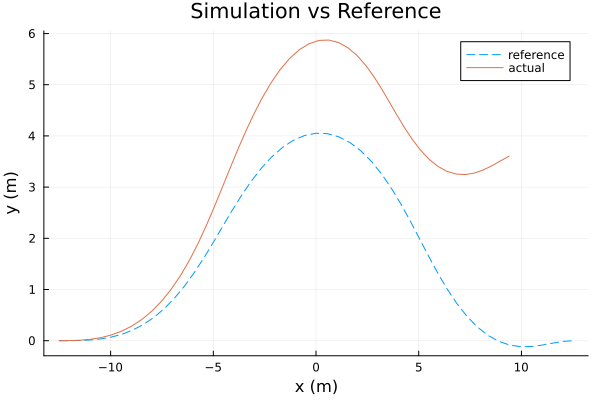

Test Summary:   |
sim to real gap | No tests


Test.DefaultTestSet("sim to real gap", Any[], 0, false, false)

In [42]:
function load_car_trajectory()
    # load in trajectory we computed offline 
    path = joinpath(@__DIR__, "utils","init_control_car_ilc.jld2")
    F = jldopen(path)
    Xref = F["X"]
    Uref = F["U"]
    close(F)
    return Xref, Uref
end
function true_car_dynamics(model::NamedTuple, x::Vector, u::Vector)::Vector
    # true car dynamics 
    px, py, θ, δ, v = x 
    a, δdot = u 
    
    # sluggish controls (not in the approximate version)
    a = 0.9*a - 0.1 
    δdot = 0.9*δdot - .1*δ + .1
    
    β = atan(model.lr * δ, model.L)
    s,c = sincos(θ + β)
    ω = v*cos(β)*tan(δ) / model.L
    
    vx = v*c 
    vy = v*s 
    
    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a
    ]
    
    return xdot 
end

@testset "sim to real gap" begin 
    # problem size 
    nx = 5
    nu = 2
    dt = 0.1
    tf = 5.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    model = (L = 2.8, lr = 1.6)
    
    # optimal trajectory computed offline with approximate model 
    Xref, Uref = load_car_trajectory()
    
    # TODO: simulated Uref with the true car dynamics and store the states in Xsim
    Xsim = [zeros(nx) for i = 1:N]
    Xsim[1] = Xref[1]
    P = ones(2,5) * -10.8
    D = ones(2,5) * 0.2
    Xlast = Xref[1]
    for i = 1:N-1
        u_next = Uref[i] - P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - Xlast)
        Xsim[i+1] = rk4(model, true_car_dynamics, Xsim[i], u_next, dt)
        Xlast = Xsim[i]
    end

    
    # --------plotting/animation-------
    Xm= hcat(Xsim...)
    Xrefm = hcat(Xref...)
    plot(Xrefm[1,:], Xrefm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "Simulation vs Reference")
    display(plot!(Xm[1,:], Xm[2,:], label = "actual"))
    
end

### Optimal PID

To encourage the trajectory of the bike to follow the reference, the objective value for this problem is the following:
$$  J(X) = \sum_{i=1}^{N-1} \bigg[ \frac{1}{2} (x_i - x_{ref,i})^TQ(x_i - x_{ref,i})]$$

We are to linearize our approximate dynamics model about $X_{ref}$ and $U_{ref}$ to get the following Jacobians:

$$ A_k = \frac{\partial f}{\partial x}\bigg|_{x_{ref,k},u_{ref,k}}, \quad \quad B_k = \frac{\partial f}{\partial u}\bigg|_{x_{ref,k},u_{ref,k}} $$

where $f(x,u)$ is our **approximate discrete** dynamics model (`estimated_car_dynamics` + `rk4`). **You will form these Jacobians exactly once, using `Xref` and `Uref`.**  Here is a summary of the notation:

- $X_{ref}$ (`Xref`) -  Optimal trajectory computed offline with approximate dynamics model. 
- $U_{ref}$ (`Uref`) -  Optimal controls computed offline with approximate dynamics model. 
- $X_{sim}$ (`Xsim`) -  Simulated trajectory with real dynamics model.


In the second step of ILC, we solve the following optimization problem:

   $$ \begin{align} \min_{\Delta x_{1:N}} \quad & J(X_{sim} + \Delta X)\\ 
 \text{st} \quad & \Delta x_1 = 0 \\ 
 & \Delta x_{k+1} = A_k \Delta x_k - P (X_{sim_k} - X_{ref_k}) - D (X_{sim_k} - X_{sim_{k-1}}) \text{ for } k = 2,3,\ldots,N-1  \\
 \end{align}$$
 

In [108]:
# feel free to use/not use any of these 

function trajectory_cost(Xsim::Vector{Vector{Float64}}, # simulated states 
                         Ubar::Vector{Vector{Float64}}, # simulated controls (ILC iterates this)
                         Xref::Vector{Vector{Float64}}, # reference X's we want to track
                         Uref::Vector{Vector{Float64}}, # reference U's we want to track 
                         Q::Matrix,                     # LQR tracking cost term 
                         R::Matrix,                     # LQR tracking cost term
                         Qf::Matrix                     # LQR tracking cost term
                         )::Float64                     # return cost J 
    
    J = 0 
    
    N = length(Xsim)

    for i = 1:N-1
        xdiff = Xsim[i] - Xref[i]
        J += (Xsim[i] - Xref[i])' * Q * (Xsim[i] - Xref[i]) 
    end
    # J += (Xsim[end] - Xref[end])' * Qf * (Xsim[end] - Xref[end])

    return J

end

function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

function ilc_update(Xsim::Vector{Vector{Float64}}, # simulated states 
                    Ubar::Vector{Vector{Float64}}, # simulated controls (ILC iterates this)
                    Xref::Vector{Vector{Float64}}, # reference X's we want to track
                    Uref::Vector{Vector{Float64}}, # reference U's we want to track 
                    As::Vector{Matrix{Float64}},   # vector of A jacobians at each time step 
                    Bs::Vector{Matrix{Float64}},   # vector of B jacobians at each time step 
                    Q::Matrix,                     # LQR tracking cost term 
                    R::Matrix,                     # LQR tracking cost term
                    Qf::Matrix                     # LQR tracking cost term
                    )     # return vector of ΔU's 

    # solve optimization problem for ILC update
    N = length(Xsim)
    nx,nu = size(Bs[1])
    
    # create variables 
    ΔX = cvx.Variable(nx, N)
    ΔU = cvx.Variable(nu, N-1)
    P = cvx.Variable(2,5)
    D = cvx.Variable(2,5)
    lambda = 0.4

    # TODO: cost function (tracking cost on Xref, Uref)
    cost = 0
    for i = 1:N-1
        xdiff = (Xsim[i] - Xref[i]) + ΔX[:,i]
        udiff = (Ubar[i] - Uref[i]) + ΔU[:,i]

        state_cost = cvx.quadform(xdiff, Q)
        control_cost = cvx.quadform(udiff, R)

        norm_cost = lambda * (cvx.LinearAlgebra.norm(vec(P), 1) + cvx.LinearAlgebra.norm(vec(D), 1))

        cost += state_cost + control_cost + norm_cost
        # cost += state_cost
    end
    # final_state_cost = cvx.quadform((Xsim[end] - Xref[end]) + ΔX[:,end], Qf)
    # cost += final_state_cost

    # problem instance 
    prob = cvx.minimize(cost)

    # TODO: initial condition constraint
    prob.constraints += ΔX[:,1] == 0

    # TODO: dynamics constraints
    xlast = Xsim[1]
    for i = 1:N-1
        ΔU[:,i] == - P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - xlast)
        prob.constraints += ΔX[:,i+1] == As[i]*ΔX[:,i] + Bs[i]*(- P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - xlast))
        xlast = Xsim[i]
    end


    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # P = vec_from_mat(P.value)
    # D = vec_from_mat(D.value)
    P = P.value
    D = D.value
    println("P = ", P)
    println("D = ", D)

    # PD = [P D]
    # println("post PD ")
    # return PD

    return P, D

    # # return ΔU 
    # ΔU = vec_from_mat(ΔU.value)

    # return ΔU
end

ilc_update (generic function with 1 method)

Here you will run your ILC algorithm. The resulting plots should show the simulated trajectory `Xsim` tracks `Xref` very closely, but there should be a significant difference between `Uref` and `Ubar`.

Pre Calculating Jacobians... 
iter     objv        |ΔU|     


------------------------------
P = [-0.8673125781153389 1.1794973459863206e-9 8.769622360156092e-11 6.556019684924647e-11 -1.0522343744052676e-10; -0.17211750637540263 -0.05343537704006032 2.972081430055013e-11 3.65019241533048e-11 -2.5321710195651962e-11]
D = [-0.5310636693877688 -1.4908036993972527e-10 -6.492008315780627e-12 1.1862443714592761e-12 -4.618922385587035e-12; 0.19686300576239973 -3.0046251888138023e-11 3.0004218671142036e-11 3.4759468607284445e-11 1.4326899532630329e-11]
  1    2.555e+03  
P = [-1.2086662654834888e-12 5.090647196954904e-13 1.8478780029999838e-13 4.427600572420641e-14 -7.856123968314319e-13; -0.0024030192945293702 1.1607776929269205e-11 8.807130210846438e-13 -2.0624103367986216e-13 -1.295747818635086e-12]
D = [0.05752021353261855 1.5236481566909796e-12 1.2509783023977264e-13 -3.331622809910422e-14 3.6708968857617366e-13; -0.0025573813965649845 7.62952308987341e-13 -1.5877638868640604e-12 -1.8513162018995634e-12 -1.606683433914419e-12]
  2    5.459e+00  
P 

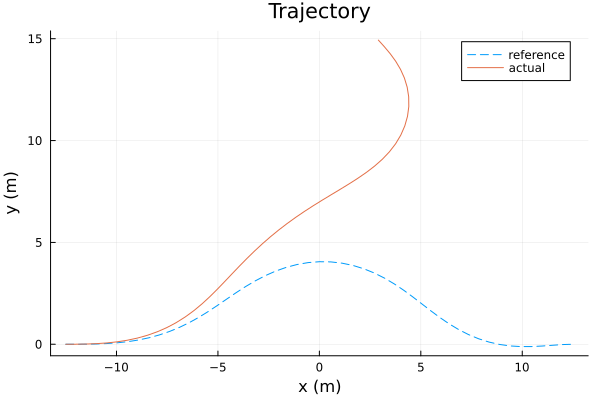

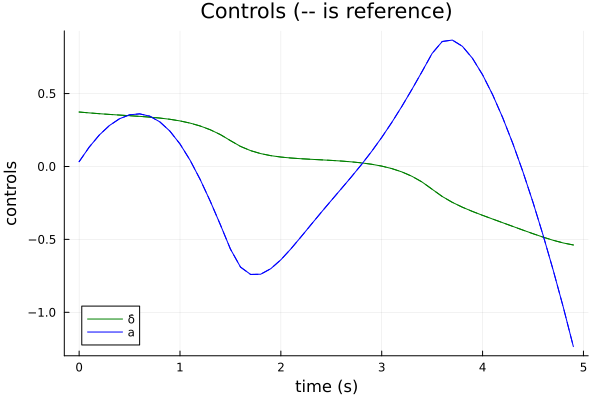

[-0.8337267179657826 3.760074715976929e-10 8.119580872888055e-11 6.488135909630819e-11 -1.2993384385422478e-10; -0.17819499949156206 -0.060586749703932935 2.975295804400172e-11 3.580422169683442e-11 -2.910955256516133e-11]
D = [-0.580434697229315 -1.4670053965433843e-10 -6.52205252190991e-12 1.230564191728534e-12 -3.679395133832867e-12; 0.2013374357278261 -2.7439757551767868e-11 2.964542833891466e-11 3.381641422348513e-11 1.3207605377517075e-11]
  3    2.587e+03  


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8718
└ @ MeshCat /Users/saraltayal/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("s23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s18" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p43" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x34, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s19" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x39], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s11" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s15" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x35], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p28" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x32, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTre

ILC: Test Failed at /Users/saraltayal/Desktop/courses/ocrl/HW4_S23-main/OptimizationProj.ipynb:106
  Expression: 0.1 <= sum(norm.(Xsim - Xref)) <= 1.0
   Evaluated: 0.1 <= 262.21793223629913 <= 1.0
Stacktrace:
 [1] macro expansion
   @ ~/Desktop/courses/ocrl/HW4_S23-main/OptimizationProj.ipynb:106 [inlined]
 [2] macro expansion
   @ /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ ~/Desktop/courses/ocrl/HW4_S23-main/OptimizationProj.ipynb:4
ILC: Test Failed at /Users/saraltayal/Desktop/courses/ocrl/HW4_S23-main/OptimizationProj.ipynb:107
  Expression: 5 <= sum(norm.(Ubar - Uref)) <= 10
   Evaluated: 5 <= 0.0 <= 10
Stacktrace:
 [1] macro expansion
   @ ~/Desktop/courses/ocrl/HW4_S23-main/OptimizationProj.ipynb:107 [inlined]
 [2] macro expansion
   @ /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Test/src/Test.jl:1151 [inlined]
 [3] top-level scope
   @ ~/Desktop/course

TestSetException: Some tests did not pass: 0 passed, 2 failed, 0 errored, 0 broken.

In [115]:
@testset "ILC" begin 
    
    # problem size 
    nx = 5
    nu = 2
    dt = 0.1
    tf = 5.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # optimal trajectory computed offline with approximate model 
    Xref, Uref = load_car_trajectory()
    
    # initial and terminal conditions 
    xic = Xref[1]
    xg = Xref[N]
    
    # LQR tracking cost to be used in ILC 
    Q = diagm([1,1,.1,.1,.1])
    R = .1*diagm(ones(nu))
    Qf = 1*diagm(ones(nx))
    
    # load all useful things into params 
    model = (L = 2.8, lr = 1.6)

    params = (Q = Q, R = R, Qf = Qf,xic = xic, xg = xg, Xref=Xref,Uref=Uref,
          dt = dt,
          N = N,
          model = model)    
    
    
    # this holds the sim trajectory (with real dynamics)
    Xsim = [zeros(nx) for i = 1:N]
    
    # this is the feedforward control ILC is updating 
    Ubar = [zeros(nu) for i = 1:(N-1)]
    Ubar .= Uref # initialize Ubar with Uref 
    
    # TODO: calculate Jacobians 
    As = [zeros(nx, nx) for i = 1:N-1]
    Bs = [zeros(nu, nu) for i = 1:N-1]

    @printf("Pre Calculating Jacobians... \n")
    for i = 1:N-1
        As[i] = FD.jacobian(dx -> rk4(model, estimated_car_dynamics, dx, Uref[i], dt), Xref[i])
        Bs[i] = FD.jacobian(du -> rk4(model, estimated_car_dynamics, Xref[i], du, dt), Uref[i])
    end

    P = zeros(2,5)
    D = zeros(2,5)
    
    # logging stuff 
    @printf "iter     objv        |ΔU|     \n"
    @printf "------------------------------\n"
    
    for ilc_iter = 1:3 # it should not take more than 10 iterations to converge 
        
        # TODO: rollout
        # Xsim[1] = xic
        # for i = 1:N-1
        #     Xsim[i+1] = rk4(model, true_car_dynamics, Xsim[i], Ubar[i], dt)
        # end
        Xsim[1] = xic
        Xlast = xic
        for i = 1:N-1
            u_next = Uref[i] - P * (Xref[i] - Xsim[i]) - D * (Xsim[i] - Xlast)
            Xsim[i+1] = rk4(model, true_car_dynamics, Xsim[i], u_next, dt)
            Xlast = Xsim[i]
        end
        # TODO: calculate objective val (trajectory_cost) 
        obj_val = trajectory_cost(Xsim, Ubar, Xref, Uref, Q, R, Qf)
        
        # solve optimization problem for update (ilc_update)
        P, D = ilc_update(Xsim, Ubar, Xref, Uref, As, Bs, Q, R, Qf)

        # logging 
        @printf("%3d   %10.3e  \n", ilc_iter, obj_val)
        
    end
    
    # --------plotting/animation-------
    Xm= hcat(Xsim...)
    Um = hcat(Ubar...)  
    Xrefm = hcat(Xref...)
    Urefm = hcat(Uref...) 
    plot(Xrefm[1,:], Xrefm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "Trajectory")
    display(plot!(Xm[1,:], Xm[2,:], label = "actual"))
    
    plot(t_vec[1:end-1], Urefm', ls = :dash, lc = [:green :blue],label = "",
         xlabel = "time (s)", ylabel = "controls", title = "Controls (-- is reference)")
    display(plot!(t_vec[1:end-1], Um', label = ["δ̇" "a"], lc = [:green :blue]))
    
    # animation
    vis = Visualizer()
    X_vis = [[x[1],x[2],0.1] for x in Xsim]
    vis_traj!(vis, :traj, X_vis; R = 0.02)
    vis_model = TrajOptPlots.RobotZoo.BicycleModel()
    TrajOptPlots.set_mesh!(vis, vis_model)
    X = [x[SA[1,2,3,4]] for x in Xsim]
    visualize!(vis, vis_model, tf, X)
    display(render(vis))
    
    # ----------testing-------------
    @test 0.1 <= sum(norm.(Xsim - Xref)) <= 1.0 # should be ~0.7 
    @test 5 <=  sum(norm.(Ubar - Uref)) <= 10 # should be ~7.7
        
end